# 1D MT Forward Modeling Example: Two-Layer Earth

This notebook demonstrates how to run the **1D MT forward model** from the `npi_mt.mt1d` module
on a simple two-layer resistivity model and plot:
- the resistivity model versus depth, and
- the MT responses (apparent resistivity and phase) versus period.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# If you're running this notebook *inside* the repository without installing the package,
# uncomment the following lines to add `src/` to your Python path.
# import sys
# from pathlib import Path
# repo_root = Path.cwd().resolve().parents[1]  # examples/ -> repo root
# sys.path.insert(0, str(repo_root / "src"))

from npi_mt.mt1d import LayeredEarthModel, MT1DForward


## Define the two-layer model

We use the following parameters:
- `test1_res = [300, 30000]` ohm·m
- `test1_depths = [0, 100, 1000]` m (interfaces)


In [2]:
test1_res = np.array([300.0, 30000.0])
test1_depths = np.array([0.0, 1e2, 1e3])

model = LayeredEarthModel(rho_ohm_m=test1_res, depth_interfaces_m=test1_depths)
fwd = MT1DForward(model)

print(f"n_layers = {model.n_layers}")
print(f"thicknesses_m = {model.thicknesses_m}")


n_layers = 2
thicknesses_m = [100. 900.]


## Build a frequency grid (log-spaced)

We create frequencies from **1e-4 to 1e4 Hz**, evenly spaced in log10.
Using **4 points per decade** gives 33 total points across 8 decades.

When plotting MT responses, we plot against **period**: `T = 1 / f`.


In [3]:
f_min, f_max = 1e-4, 1e4
points_per_decade = 4
n_decades = int(round(np.log10(f_max) - np.log10(f_min)))
n_freq = n_decades * points_per_decade + 1

freqs_hz = np.logspace(np.log10(f_min), np.log10(f_max), n_freq)
period_s = 1.0 / freqs_hz

print(f"n_freq = {n_freq} (≈ {points_per_decade} per decade)")


n_freq = 33 (≈ 4 per decade)


## Run the forward model


In [4]:
resp = fwd.predict(freqs_hz)

app_res = resp.app_res_ohm_m
phase_deg = resp.phase_deg

print(app_res.shape, phase_deg.shape)


(33,) (33,)


## Plot the resistivity model versus depth

We draw a piecewise-constant step profile using the layer interfaces.


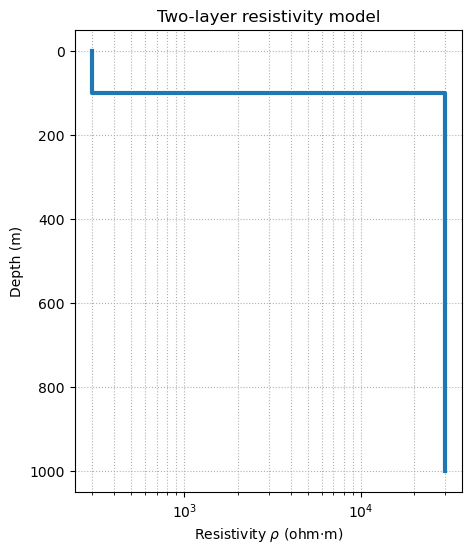

In [5]:
# Build a step-style profile from interfaces
z = test1_depths
rho = test1_res

# For Z layers, interfaces have length Z+1.
# Create step coordinates: (rho1 from z0->z1), (rho2 from z1->z2), ...
rho_step = np.repeat(rho, 2)
z_step = np.empty(rho_step.size, dtype=float)
z_step[0::2] = z[:-1]
z_step[1::2] = z[1:]

plt.figure(figsize=(5, 6))
plt.plot(rho_step, z_step, lw=3)
plt.gca().invert_yaxis()
plt.xscale('log')
plt.xlabel(r"Resistivity $\rho$ (ohm·m)")
plt.ylabel("Depth (m)")
plt.title("Two-layer resistivity model")
plt.grid(True, which='both', ls=':')
plt.show()


## Plot MT responses versus period

- Apparent resistivity is typically shown on log–log axes.
- Phase is shown versus period (log x-axis), in degrees.


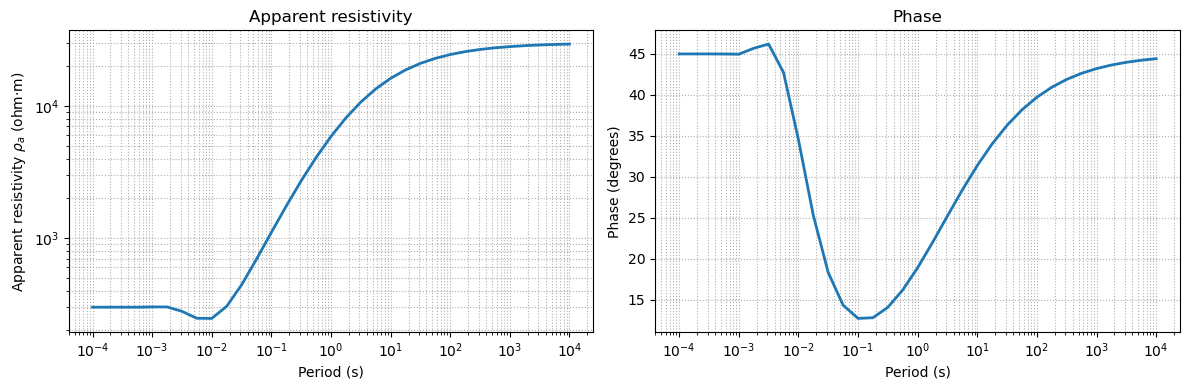

In [6]:
# Sort by increasing period for plotting (period increases as frequency decreases)
order = np.argsort(period_s)
T = period_s[order]
rho_a = app_res[order]
phi = phase_deg[order]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.loglog(T, rho_a, lw=2)
ax1.set_xlabel("Period (s)")
ax1.set_ylabel(r"Apparent resistivity $\rho_a$ (ohm·m)")
ax1.set_title("Apparent resistivity")
ax1.grid(True, which='both', ls=':')

ax2.semilogx(T, phi, lw=2)
ax2.set_xlabel("Period (s)")
ax2.set_ylabel("Phase (degrees)")
ax2.set_title("Phase")
ax2.grid(True, which='both', ls=':')

plt.tight_layout()
plt.show()
